In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from lightjob.cli import load_db
from lightjob.db import SUCCESS
import collections
import json
import pandas as pd
import numpy as np
from tpot import TPOTClassifier, TPOTRegressor
from xgboost import XGBRegressor
from IPython.display import Image
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import KFold, train_test_split, ShuffleSplit
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def json_to_vec():
    pass

def flatten_dict(l):
    d = {}
    for k, v in l.items():
        if isinstance(v, collections.Mapping):
            d.update(flatten_dict(v))
        elif isinstance(v, list) or isinstance(v, tuple):
            for i, l in enumerate(v):
                d[k+'_{}'.format(i)] = l
        else:
            d[k] = v
    return d

def plot_imp(names, values):
    ind = (np.arange(len(names)))
    plt.xticks(ind + 0.5, names)
    plt.bar(ind, values, width=1)
    plt.xlabel('variable index')i
    plt.ylabel('importance')

class EnsembleRegressor(object):
    def __init__(self, regs=None):
        self.regs = regs

    def fit(self, X, y):
        return self

    def predict(self, X, return_std=False):
        if return_std:
            means = []
            stds = []
            for r in self.regs:
                m, s = r.predict(X, return_std=True)
                means.append(m)
                stds.append(s)
            means = np.vstack(means).T
            stds = np.vstack(stds).T
            return np.mean(means, axis=1), (np.sqrt((stds**2).sum(axis=1)) / stds.shape[1])
        else:
            preds = np.vstack([r.predict(X) for r in self.regs]).T
            return np.mean(preds, axis=1)


/home/ubuntu/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
db = load_db(folder='../../feature_generation/.lightjob')

In [3]:
jobs = list(db.jobs_with(state=SUCCESS, type='training'))
jobs = filter(lambda j:j['content']['dataset'] == 'digits', jobs)

In [4]:
for j in jobs:
    print(j['stats']['training']['avg_loss_train_details'])
    break

{u'50per': 54.85158047638317, u'90per': 53.820155732562135, u'5per': 55.28937117287276, u'70per': 54.51151175866086, u'30per': 54.312614499544196, u'10per': 54.41327650537736}


In [5]:
df = pd.DataFrame()
df['hypers'] = [j['content'] for j in jobs]
cst = 784.
def get_details(name, subname, j):
    if name + '_details' in j['stats']['training']:
        return j['stats']['training']['avg_loss_train_fix_details'][subname] / cst
    else:
        return np.nan
    
earlys = ('5per', '10per', '30per', '50per', '70per', '90per')
for k in earlys:
    df['avg_loss_train_early_'  + k] = [get_details('avg_loss_train_fix', k, j)  for j in jobs]
df['avg_loss_train'] = [j['stats']['training'].get('avg_loss_train_fix', np.nan) / cst  for j in jobs]
df['jobset'] = [j['where'] for j in jobs]

In [6]:
colnames = set()
for i in range(len(df)):
    h = df['hypers'].iloc[i]
    h = flatten_dict(h)
    colnames |= set(h.keys())
colnames = list(colnames)
for col in colnames:
    df[col] = df.apply(lambda r:flatten_dict((r['hypers'])).get(col), axis=1)
df = df.dropna(axis=0, subset=['avg_loss_train'])
for k in earlys:
    df = df.dropna(axis=0, subset=['avg_loss_train_early_' + k])

In [7]:
cols = ['avg_loss_train_early_' + k for k in earlys[0:2]]
cols += colnames
df_x = df[cols]
df_x = df_x.fillna(-1)
df_x = pd.get_dummies(df_x)
df_y = df['avg_loss_train']
df_y_rel = (df[cols[1]] - df['avg_loss_train']) / (df['avg_loss_train'])

In [8]:
X_vect = df_x.values
y_vect = df_y.values
cols = (df_x.columns.values)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_vect, y_vect, test_size=0.2)

In [10]:
from sklearn.base import clone

kernel = RBF()
#reg = Ridge(alpha=10)
#reg = LinearRegression()
#reg = RandomForestRegressor(n_estimators=10, max_depth=10)
#reg = DecisionTreeRegressor(max_depth=10, random_state=1)
reg = GaussianProcessRegressor(normalize_y=True, n_restarts_optimizer=10)
scores = []
#for train, test in StratifiedShuffleSplit(y, n_iter=10, test_size=0.9, random_state=2):

reg_orig = clone(reg)

def S(reg, x, y):
    return np.abs(reg.predict(x) - y).mean()
    #return (np.abs(reg.predict(x) - y)/(y)).mean()
print('train    valid')
regs = []

#for train, test in ShuffleSplit(len(X_train), n_iter=10, test_size=0.2, random_state=2):
for train, test in KFold(len(X_train), n_folds=5, shuffle=True, random_state=2):
    reg = clone(reg_orig)
    reg.fit(X_train[train], y_train[train])
    print('{:.5f} {:.5f}'.format(S(reg, X_train[train], y_train[train]), S(reg, X_train[test], y_train[test])))
    score = S(reg, X_train[test], y_train[test])
    scores.append(score)
    regs.append(reg)
print('mean valid:')
print(np.mean(scores), np.std(scores))

train    valid
0.00003 0.01633
0.00002 0.01639
0.00003 0.01456
0.00003 0.01654
0.00002 0.01598
mean valid:
(0.015957520347367887, 0.00072375260028209793)


In [11]:
final_reg = EnsembleRegressor(regs)
for r in regs:
    print(S(r, X_test, y_test))
print('ens:')
print(S(final_reg, X_test, y_test))
m, s = final_reg.predict(X_test, return_std=True)
mr, sr = reg.predict(X_test, return_std=True)

0.0206489505572
0.0202150497009
0.0217006186461
0.020169049381
0.020348446261
ens:
0.0195695069546


/home/ubuntu/work/code/external/scikit-learn/sklearn/gaussian_process/gpr.py:304: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [12]:
print('ens std avg:', np.sqrt((s**2).sum()/(len(s)**2)))
print('one std avg:', np.sqrt((sr**2).sum()/(len(sr)**2)))

('ens std avg:', 0.013862360073774345)
('one std avg:', 0.031040349437140562)


In [13]:
pd.DataFrame({'pred': m*784, 'std': s*784,  'std_r':sr*784, 'real': y_test * 784}).sample(30)

,pred,real,std,std_r
195,8.983374,8.987247,1.371668,2.773740
383,21.620930,23.788352,3.492512,3.221785
116,33.457085,22.182833,340.182097,755.355604
115,18.261424,7.759095,276.933253,560.067863
208,10.255610,14.873201,2.577698,5.040628
17,41.557417,44.386430,12.122965,1.930693
80,14.830377,14.636203,0.544207,0.473687
252,33.299917,4.037952,350.615453,784.000000
79,7.964585,7.976346,1.356004,2.706893
149,33.305195,74.753866,350.615459,784.000000


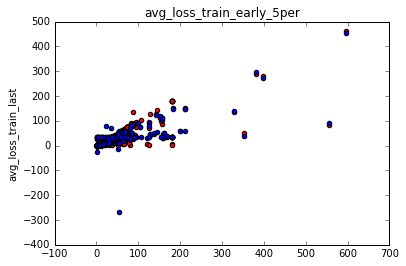

In [14]:
plt.scatter(X_test[:, 0]*cst, y_test*cst, c='r')
plt.scatter(X_test[:, 0]*cst, final_reg.predict(X_test)*cst, c='b')
plt.title(cols[0])
plt.ylabel('avg_loss_train_last')

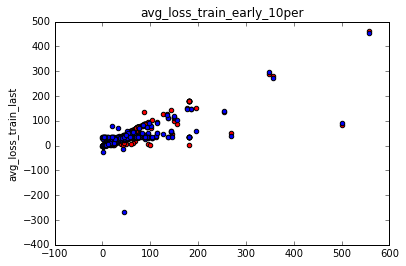

In [15]:
plt.scatter(X_test[:, 1]*cst, y_test*cst, c='r')
plt.scatter(X_test[:, 1]*cst, final_reg.predict(X_test)*cst, c='b')
plt.title(cols[1])
plt.ylabel('avg_loss_train_last')

In [16]:
print((s>sr).mean())

0.25


In [23]:
import collections
import pandas as pd

def dicts_to_dataframes(dlist, colnames=None):
    dlist = map(flatten_dict, dlist)
    colnames = set(k for d in dlist for k in d.keys())
    df = pd.DataFrame()
    df = pd.DataFrame(dlist)
    #for col in colnames:
    #    df[col] = [d.get(col) for d in dlist]
    return df

def flatten_dict(l):
    d = {}
    for k, v in l.items():
        if isinstance(v, collections.Mapping):
            d.update(flatten_dict(v))
        elif isinstance(v, list) or isinstance(v, tuple):
            for i, l in enumerate(v):
                d[k+'_{}'.format(i)] = l
        else:
            d[k] = v
    return d
  
dataset = [
  {'a': 4, 'b': 2},
  {'a': 5, 'b': 3},
  {'b': 10}
]
dataset = dicts_to_dataframes(dataset)
print(dataset)

     a   b
0  4.0   2
1  5.0   3
2  NaN  10


(4, 2)


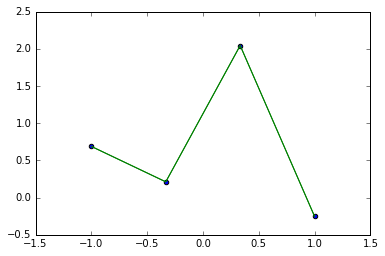

In [113]:
from sklearn.gaussian_process import GaussianProcessRegressor
nb = 10
x = np.linspace(-1, 1, 4)
y = x**2 + np.random.normal(0, 1, size=x.shape)
gp = GaussianProcessRegressor()

gp.fit(x[:, np.newaxis] ,y)
plt.scatter(x, y)

ypred = gp.predict(x[:, np.newaxis])
y_s = gp.sample_y(x[:, np.newaxis], n_samples=2)
print(y_s.shape)
#plt.scatter(x, ypred, c='r')
plt.plot(x, y_s, c='g')